# Lyzenga Method
I want to apply the Lyzenga 2006 method for comparison.

In [1]:
%pylab inline
import geopandas as gpd
import pandas as pd
from OpticalRS import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
import itertools
import statsmodels.formula.api as smf
from collections import OrderedDict
style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../data

/home/jkibele/Copy/JobStuff/PhD/iPythonNotebooks/DepthPaper/data


## Preprocessing
That happened [here](../ClassificationDev/Lyzenga/Lyzenga2006/Lyzenga2006.ipynb#Preprocessing-My-Imagery).

In [3]:
imrds = RasterDS('glint_corrected.tif')
imarr = imrds.band_array
deprds = RasterDS('Leigh_Depth_atAcq_Resampled.tif')
darr = -1 * deprds.band_array.squeeze()

## Depth Limit
Lyzenga et al methods for determining shallow water don't work for me based on the high reflectance of the water column and extremely low reflectance of Ecklonia for the blue bands. So I'm just going to limit the depths under consideration using the multibeam data.

In [4]:
darr = np.ma.masked_greater( darr, 20.0 )

## Equalize Masks
I need to make sure I'm dealing with the same pixels in depth and image data.

In [5]:
imarr = ArrayUtils.mask3D_with_2D( imarr, darr.mask )
darr = np.ma.masked_where( imarr[...,0].mask, darr )

## Dark Pixel Subtraction
I need to calculate a modified version of $X_i = ln(L_i - L_{si})$. In order to do that I'll first load the deep water means and standard deviations I calculated [here](ImageryPreprocessing.ipynb).

In [6]:
dwmeans = np.load('darkmeans.pkl')
dwstds = np.load('darkstds.pkl')

I applied the same modification as Armstrong (1993), 2 standard deviations from $L_{si}$, to avoid getting too many negative values because those can't be log transformed.

In [7]:
dpsub = ArrayUtils.equalize_band_masks( \
                    np.ma.masked_less( imarr - (dwmeans - 2 * dwstds), 0.0 ) )

In [8]:
print "After that I still retain %.1f%% of my pixels." % ( 100 * dpsub.count() / float( imarr.count() ) )

After that I still retain 100.0% of my pixels.


In [9]:
X = np.log( dpsub )

In [11]:
# imrds.new_image_from_array(X.astype('float32'),'LyzengaX.tif')

I'll need to equalize the masks again. I'll call the depths h in reference to Lyzenga et al. 2006 (e.g. equation 14).

In [10]:
h = np.ma.masked_where( X[...,0].mask, darr )

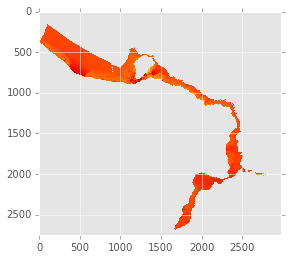

In [11]:
imshow( X[...,1] )

## Dataframe
Put my $X_i$ and my $h$ values into a dataframe so I can regress them easily.

In [12]:
df = ArrayUtils.band_df( X )
df['depth'] = h.compressed()

## Data Split
I need to split my data into training and test sets.

In [13]:
x_train, x_test, y_train, y_test = train_test_split( \
            df[imrds.band_names],df.depth,train_size=300000,random_state=5)
traindf = ArrayUtils.band_df( x_train )
traindf['depth'] = y_train.ravel()
testdf = ArrayUtils.band_df( x_test )
testdf['depth'] = y_test.ravel()

## Find the Best Band Combo
That's the one that returns the largest $R^2$ value.

In [14]:
def get_fit( ind, x_train, y_train ):
    skols = LinearRegression()
    skolsfit = skols.fit(x_train[...,ind],y_train)
    return skolsfit

In [15]:
def get_selfscore( ind, x_train, y_train ):
    fit = get_fit( ind, x_train, y_train )
    return fit.score( x_train[...,ind], y_train )

In [16]:
od = OrderedDict()
for comb in itertools.combinations( range(8), 2 ):
    od[ get_selfscore(comb,x_train,y_train) ] = [ c+1 for c in comb ]
od_sort = sorted( od.items(), key=lambda t: t[0], reverse=True )
od_sort

[(0.62755055995699083, [2, 3]),
 (0.51117453631243359, [1, 3]),
 (0.46285789217335149, [4, 8]),
 (0.46103699346871774, [4, 7]),
 (0.42177726267216331, [3, 7]),
 (0.40406518813740255, [5, 7]),
 (0.40245212485503301, [3, 8]),
 (0.38927723350745969, [5, 8]),
 (0.38907953866338507, [7, 8]),
 (0.3889196148715951, [2, 7]),
 (0.38834356672734605, [1, 7]),
 (0.38822052932239726, [6, 7]),
 (0.35019465511156112, [6, 8]),
 (0.3451119590366919, [1, 8]),
 (0.34487505932595763, [2, 8]),
 (0.33048699409816018, [1, 4]),
 (0.28101837458788692, [1, 5]),
 (0.1979905528500211, [1, 2]),
 (0.17614990512640638, [2, 5]),
 (0.17157304531946738, [3, 5]),
 (0.16217057826369075, [3, 6]),
 (0.15511067503217324, [2, 4]),
 (0.15424195535233254, [1, 6]),
 (0.14122890381874853, [3, 4]),
 (0.12792627558016711, [5, 6]),
 (0.10966281196382133, [4, 5]),
 (0.09477791747767994, [4, 6]),
 (0.076484874451846263, [2, 6])]

In [17]:
best_ind = np.array( od_sort[0][1] ) - 1
best_ind

array([1, 2])

## Build the model

In [18]:
skols = LinearRegression()
skolsfit = skols.fit(x_train[...,best_ind],y_train)

In [21]:
print "h0 = %.2f, h2 = %.2f, h3 = %.2f" % \
            (skolsfit.intercept_,skolsfit.coef_[0],skolsfit.coef_[1])

h0 = 17.08, h2 = 16.06, h3 = -16.16


## Check the Results

In [26]:
print "R^2 = %.6f" % skolsfit.score(x_test[...,best_ind],y_test)

R^2 = 0.629596


In [27]:
pred = skolsfit.predict(x_test[...,best_ind])

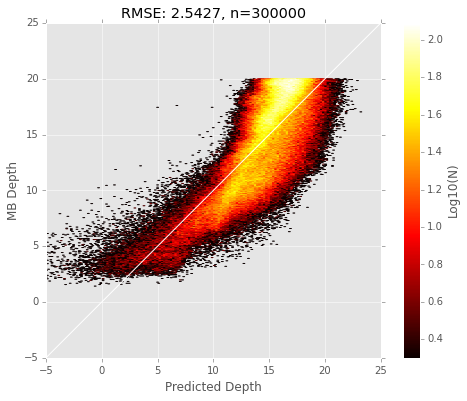

In [28]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
mapa = ax.hexbin(pred,y_test,mincnt=1,bins='log',gridsize=500,cmap=plt.cm.hot)
# ax.scatter(pred,y_test,alpha=0.008,edgecolor='none')
ax.set_ylabel('MB Depth')
ax.set_xlabel('Predicted Depth')
rmse = np.sqrt( mean_squared_error( y_test, pred ) )
n = x_train.shape[0]
tit = "RMSE: %.4f, n=%i" % (rmse,n)
ax.set_title(tit)
ax.set_aspect('equal')
ax.axis([-5,25,-5,25])
ax.plot([-5,25],[-5,25],c='white')
cb = plt.colorbar(mapa)
cb.set_label("Log10(N)")

In [29]:
LyzPredVsMB = pd.DataFrame({'prediction':pred,'mb_depth':y_test})
LyzPredVsMB.to_pickle('LyzPredVsMB.pkl')

### Effect of Depth Limit on Model Accuracy
Given a fixed number of training points (n=1500), what is the effect of limiting the depth of the model.

In [30]:
fullim = imrds.band_array
fulldep = -1 * deprds.band_array.squeeze()
fullim = ArrayUtils.mask3D_with_2D( fullim, fulldep.mask )
fulldep = np.ma.masked_where( fullim[...,0].mask, fulldep )

In [31]:
dlims = arange(5,31,2.5)
drmses,meanerrs,stderrs = [],[],[]
for dl in dlims:
    dlarr = np.ma.masked_greater( fulldep, dl )
    iml = ArrayUtils.mask3D_with_2D( fullim, dlarr.mask )
    imldsub = ArrayUtils.equalize_band_masks( \
                            np.ma.masked_less( iml - (dwmeans - 2 * dwstds), 0.0 ) )
    imlX = np.log( imldsub )
    dlarr = np.ma.masked_where( imlX[...,0].mask, dlarr )
    xl_train, xl_test, yl_train, yl_test = train_test_split( \
            imlX.compressed().reshape(-1,8),dlarr.compressed(),train_size=1500,random_state=5)
    linr = LinearRegression()
    predl = linr.fit(xl_train[...,best_ind],yl_train).predict( xl_test[...,best_ind] )
    drmses.append( sqrt( mean_squared_error(yl_test,predl) ) )
    meanerrs.append( (yl_test - predl).mean() )
    stderrs.append( (yl_test - predl).std() )

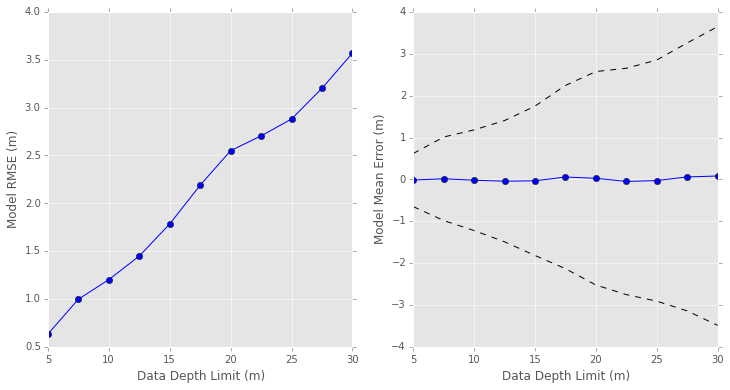

In [32]:
fig,(ax1,ax2) = subplots(1,2,figsize=(12,6))
ax1.plot(dlims,np.array(drmses),marker='o',c='b')
ax1.set_xlabel("Data Depth Limit (m)")
ax1.set_ylabel("Model RMSE (m)")
em,es = np.array(meanerrs), np.array(stderrs)
ax2.plot(dlims,em,marker='o',c='b')
ax2.plot(dlims,em+es,linestyle='--',c='k')
ax2.plot(dlims,em-es,linestyle='--',c='k')
ax2.set_xlabel("Data Depth Limit (m)")
ax2.set_ylabel("Model Mean Error (m)")

In [33]:
deplimdf = pd.DataFrame({'depth_lim':dlims,'rmse':drmses,\
                         'mean_error':meanerrs,'standard_error':stderrs})

In [34]:
deplimdf.to_pickle('LyzengaDepthLimitDF.pkl')

## Limited Training Data
I want to see how the accuracy of this method is affected by the reduction of training data.

In [111]:
# ns = np.logspace(log10(0.00003*df.depth.count()),log10(0.80*df.depth.count()),15)
int(ns.min()),int(ns.max())

(19, 515870)

In [112]:
ns = np.logspace(1,log10(0.80*df.depth.count()),15)
ltdf = pd.DataFrame({'train_size':ns})
for rs in range(10):
    nrmses = []
    for n in ns:
        xn_train,xn_test,yn_train,yn_test = train_test_split( \
                df[imrds.band_names],df.depth,train_size=int(n),random_state=rs+100)
        thisols = LinearRegression()
        npred = thisols.fit(xn_train[...,best_ind],yn_train).predict(xn_test[...,best_ind])
        nrmses.append( sqrt( mean_squared_error(yn_test,npred ) ) )
    dflabel = 'rand_state_%i' % rs
    ltdf[dflabel] = nrmses
print "min points: %i, max points: %i" % (int(ns.min()),int(ns.max()))

min points: 10, max points: 515870


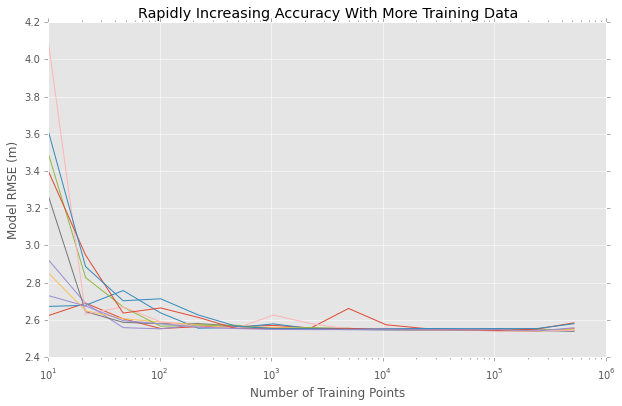

In [113]:
fig,ax = subplots(1,1,figsize=(10,6))
for rs in range(10):
    dflabel = 'rand_state_%i' % rs
    ax.plot(ltdf['train_size'],ltdf[dflabel])
ax.set_xlabel("Number of Training Points")
ax.set_ylabel("Model RMSE (m)")
# ax.set_xlim(0,5000)
ax.set_xscale('log')
ax.set_title("Rapidly Increasing Accuracy With More Training Data")

In [114]:
ltdf.to_pickle('LyzengaAccuracyDF.pkl')

## Full Prediction
Perform a prediction on all the data and find the errors. Save the outputs for comparison with KNN.

In [46]:
full_pred = skolsfit.predict(X[...,best_ind])
full_pred = np.ma.masked_where( h.mask, full_pred )

In [47]:
full_errs = full_pred - h

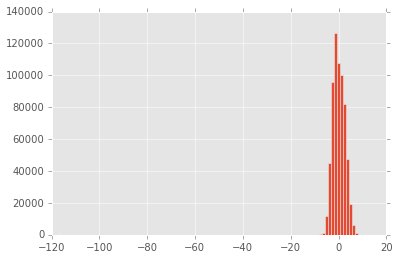

In [48]:
blah = hist( full_errs.compressed(), 100 )

<matplotlib.colorbar.Colorbar instance at 0x7fabb91013b0>

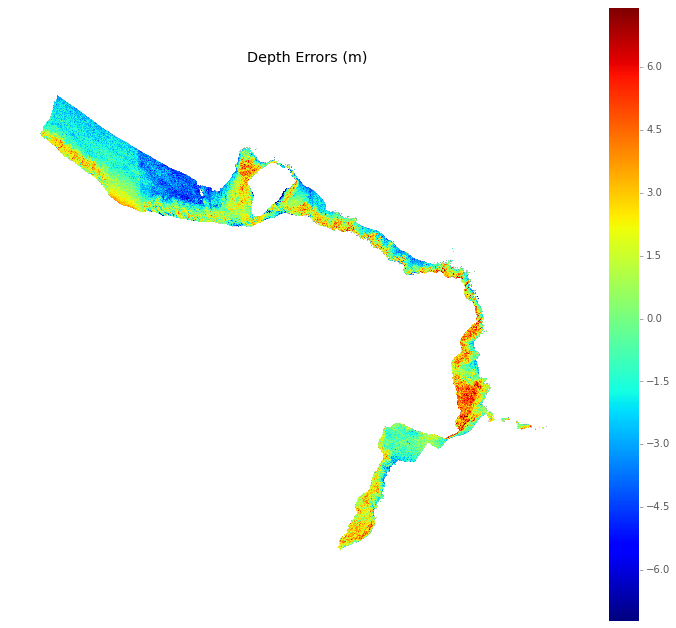

In [49]:
figure(figsize=(12,11))
vmin,vmax = np.percentile(full_errs.compressed(),0.1),np.percentile(full_errs.compressed(),99.9)
imshow( full_errs, vmin=vmin, vmax=vmax )
ax = gca()
ax.set_axis_off()
ax.set_title("Depth Errors (m)")
colorbar()

In [50]:
full_pred.dump('LyzDepthPred.pkl')
full_errs.dump('LyzDepthPredErrs.pkl')